In [ ]:
# Importing all the necessary libraries and modules
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator, Aer
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler, EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt
import pickle
import numpy as np


1. Create the circuit for superdense coding (using 2 qubits and 2 classical bits) and check its validity using Statevector for all the 4 possible cases.

In [2]:
def circuiting(input):
    """Creates the superdense coding circuit for a given 2-bit classical message"""
    
    # Creating a 2-qubit circuit and 2 classical bits
    q = QuantumRegister(2, 'q')
    c = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    circuit.h(0)           
    circuit.cx(0, 1)       

    if input == '00':
        pass  
    elif input == '01':
        circuit.z(0)
    elif input == '10':
        circuit.x(0)
    elif input == '11':
        circuit.z(0)
        circuit.x(0)

    circuit.cx(0, 1)
    circuit.h(0)

    circuit.measure(0, 0)
    circuit.measure(1, 1)

    return circuit

In [3]:
bitstrings = ['00', '01', '10', '11']

In [4]:
from qiskit import transpile

simulator = AerSimulator()

for bits in bitstrings:
    circuit_no_measure = circuiting(bits).remove_final_measurements(inplace=False)
    
    # Get final statevector and find the dominant state
    final_state = Statevector.from_instruction(circuit_no_measure)
    dominant_state = np.argmax(np.abs(final_state.data)**2)
    binary_representation = format(dominant_state, '02b') # Find the correspnding binary form of the array position of highest probability

    print(f"Input: {bits} → Output: {binary_representation} ")


Input: 00 → Output: 00 
Input: 01 → Output: 01 
Input: 10 → Output: 10 
Input: 11 → Output: 11 



2. Run it on AerSimulator (no noise) and Real Quantum Hardware (1024 shots for both) for transmitting the classical bits 11 and find how many times do you send correct message by plotting histogram.

AerSimulator Counts: {'11': 1024}


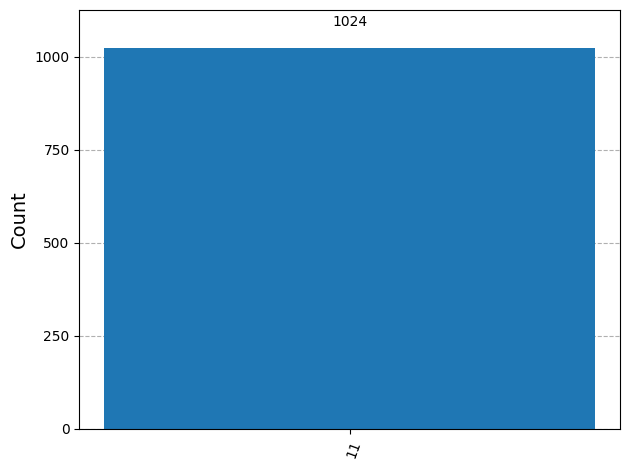

In [5]:
sim = AerSimulator()
qc = circuiting('11')
tqc = transpile(qc, sim)

job_sim = sim.run(tqc, shots=1024)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts()

print("AerSimulator Counts:", counts_sim)
plot_histogram(counts_sim)

# Surprise surprise, its a single line :/

In [6]:
token = '7eac5e4e702e3146e4043879aff4cb905f3bb2d4372d7358eb8bead26fb84691cc20e010b7f834e39645ac12763b6915f066db4a1a28992da39356a5b768ea8b'
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(operational=True, min_num_qubits=5)
print("Running on:", backend.name)

/var/folders/10/n59cq8_939x8yv9swss8dkp00000gn/T/ipykernel_93039/2367327277.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum", token=token)


Running on: ibm_sherbrooke


/opt/miniconda3/envs/qiskit/lib/python3.13/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


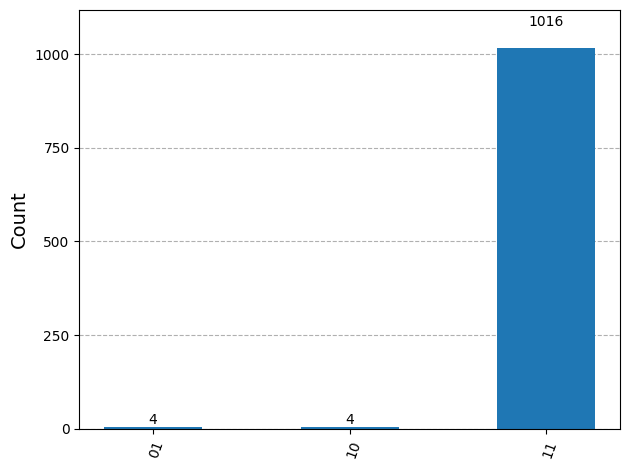

In [10]:
ttqc = transpile(qc,backend, optimization_level=2)
sampler = Sampler(mode=backend)
job = sampler.run([ttqc],shots=1024)  
result = job.result()
pub_result = result[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

In [11]:
def word_to_binary(word):
    binary = ''.join(format(ord(c), '08b') for c in word)
    return binary 


def binary_to_word(binary_str):
    # Pad with zeros if length not multiple of 8
    padded = binary_str.ljust((len(binary_str) + 7) // 8 * 8, '0')
    return ''.join(chr(int(padded[i:i+8], 2)) for i in range(0, len(padded), 8))

In [12]:

code = "Gautam"
binary_code = word_to_binary(code)
print(f"Binary representation of '{code}': {binary_code}")

backend = AerSimulator()
decoded_bits = ""


for i in range(0, len(binary_code), 2):
    bits = binary_code[i:i+2]
    print(f"Processing bits: {bits}")
    qc = circuiting(bits)

    tqc = transpile(qc, backend)

    job = backend.run(tqc, shots=1024)
    result = job.result()

    counts = result.get_counts()
    received = max(counts, key=counts.get)
    decoded_bit = received 

    print(f"Decoded bits: {decoded_bit}")
    decoded_bits += decoded_bit




Binary representation of 'Gautam': 010001110110000101110101011101000110000101101101
Processing bits: 01
Decoded bits: 01
Processing bits: 00
Decoded bits: 00
Processing bits: 01
Decoded bits: 01
Processing bits: 11
Decoded bits: 11
Processing bits: 01
Decoded bits: 01
Processing bits: 10
Decoded bits: 10
Processing bits: 00
Decoded bits: 00
Processing bits: 01
Decoded bits: 01
Processing bits: 01
Decoded bits: 01
Processing bits: 11
Decoded bits: 11
Processing bits: 01
Decoded bits: 01
Processing bits: 01
Decoded bits: 01
Processing bits: 01
Decoded bits: 01
Processing bits: 11
Decoded bits: 11
Processing bits: 01
Decoded bits: 01
Processing bits: 00
Decoded bits: 00
Processing bits: 01
Decoded bits: 01
Processing bits: 10
Decoded bits: 10
Processing bits: 00
Decoded bits: 00
Processing bits: 01
Decoded bits: 01
Processing bits: 01
Decoded bits: 01
Processing bits: 10
Decoded bits: 10
Processing bits: 11
Decoded bits: 11
Processing bits: 01
Decoded bits: 01


In [13]:
print(f"Decoded bits: {decoded_bits}")
decoded_word = binary_to_word(decoded_bits)
print(f"Decoded word from binary '{binary_code}': {decoded_word}")


Decoded bits: 010001110110000101110101011101000110000101101101
Decoded word from binary '010001110110000101110101011101000110000101101101': Gautam


In [14]:
backend = service.backend("ibm_sherbrooke")

In [16]:

# this should work, im guessing i used a bit too much so its kinda slow right now
decoded_bits = ""
print(backend.name)
sampler = Sampler(mode=backend)
for i in range(0, len(binary_code), 2):
    bits = binary_code[i:i+2]
    print(f"Processing bits: {bits}")
    qc = circuiting(bits)

    tqc = transpile(qc, backend)

    job = sampler.run([tqc], shots=1024)  
    result = job.result()

    pub_result = result[0]
    print(pub_result.data.c.get_counts())
    counts = pub_result.data.c.get_counts()
    received = max(counts, key=counts.get)
    decoded_bit = received 

    print(f"Decoded bits: {decoded_bit}")
    decoded_bits += decoded_bit

ibm_sherbrooke
Processing bits: 01
{'01': 1017, '00': 6, '11': 1}
Decoded bits: 01
Processing bits: 00
{'00': 1021, '01': 2, '10': 1}
Decoded bits: 00
Processing bits: 01
{'01': 1011, '00': 11, '11': 2}
Decoded bits: 01
Processing bits: 11


KeyboardInterrupt: 

In [ ]:
print(f"Decoded bits: {decoded_bits}")
decoded_word = binary_to_word(decoded_bits)
print(f"Decoded word from binary '{binary_code}': {decoded_word}")

Decoded bits: 
Decoded word from binary '010001110110000101110101011101000110000101101101': 


In [ ]:

noise = NoiseModel()
error = depolarizing_error(0.5, 1)  
error_2q = depolarizing_error(0.5, 2)

# So the noise model just didn't give enough ..... noise ..... so i added this error adding thing but unless its set at 1 even it doesnt give much error :(

noise.add_all_qubit_quantum_error(error, ['x', 'h','id'])
noise.add_all_qubit_quantum_error(error_2q, ['cx'])
with open("ibm_brisbane_noise_model.pkl", "rb") as f:
    noise_model, basis_gates = pickle.load(f)
sim = AerSimulator(
    noise_model=noise,
    basis_gates= basis_gates
)


In [ ]:

decoded_word = ""
decoded_bits = ""

for i in range(0, len(binary_code), 2):
    bits = binary_code[i:i+2]
    print(f"Processing bits: {bits}")
    qc = circuiting(bits)
    qc_compiled = transpile(qc, sim)
    job_sim = sim.run(qc_compiled, shots=1024, optimization_level=0)

    result_sim = job_sim.result()

    counts = result_sim.get_counts(qc_compiled)
    print(counts)
    received = max(counts, key=counts.get)
    decoded_bit = received 
    print(f"Decoded bits: {decoded_bit}")
    decoded_bits += decoded_bit

Processing bits: 01
{'01': 747, '00': 277}
Decoded bits: 01
Processing bits: 00
{'00': 1024}
Decoded bits: 00
Processing bits: 01
{'01': 769, '00': 255}
Decoded bits: 01
Processing bits: 11
{'01': 195, '10': 179, '00': 77, '11': 573}
Decoded bits: 11
Processing bits: 01
{'00': 248, '01': 776}
Decoded bits: 01
Processing bits: 10
{'00': 242, '10': 782}
Decoded bits: 10
Processing bits: 00
{'00': 1024}
Decoded bits: 00
Processing bits: 01
{'01': 774, '00': 250}
Decoded bits: 01
Processing bits: 01
{'00': 232, '01': 792}
Decoded bits: 01
Processing bits: 11
{'01': 166, '11': 588, '00': 65, '10': 205}
Decoded bits: 11
Processing bits: 01
{'01': 766, '00': 258}
Decoded bits: 01
Processing bits: 01
{'00': 254, '01': 770}
Decoded bits: 01
Processing bits: 01
{'00': 277, '01': 747}
Decoded bits: 01
Processing bits: 11
{'01': 177, '00': 60, '10': 214, '11': 573}
Decoded bits: 11
Processing bits: 01
{'00': 259, '01': 765}
Decoded bits: 01
Processing bits: 00
{'00': 1024}
Decoded bits: 00
Process

In [ ]:
print(backend.name)
print(sim.name)
print(f"Decoded bits: {decoded_bits}")
decoded_word = binary_to_word(decoded_bits)
print(f"Decoded word from binary '{binary_code}': {decoded_word}")


ibm_brisbane
aer_simulator
Decoded bits: 010001110110000101110101011101000110000101101101
Decoded word from binary '010001110110000101110101011101000110000101101101': Gautam
